Versi TensorFlow: 2.18.0
Versi TF Hub: 0.16.1
Pilih input media:
Ketik 'url' untuk link gambar/video, atau 'file' untuk unggah file: file


Saving 67c12bad3c864.jpg to 67c12bad3c864.jpg

Apakah ingin menghitung jumlah objek?
Ketik 'ya' untuk menghitung, atau 'tidak' untuk tidak: ya

Pilih kategori yang ingin dihitung:
Ketik 'semua' untuk semua kategori, atau ketik kategori manual (pisahkan dengan koma)
Kategori: semua

=== Hasil Perhitungan Objek ===
- kereta: 1
- manusia: 14
- ski: 2


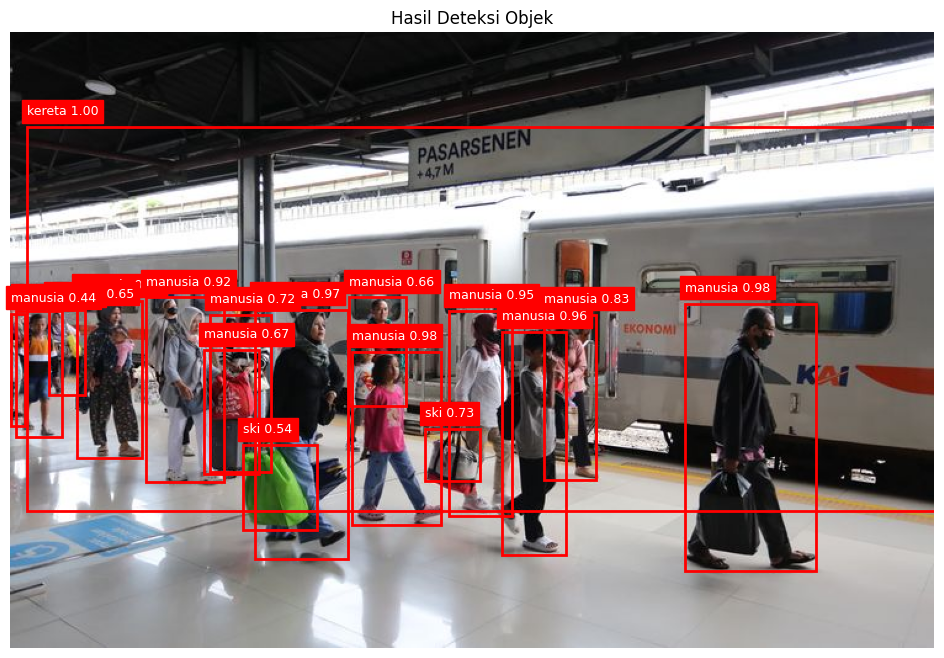

In [15]:
# Cell 1: Import Library
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import cv2
from google.colab import files

print("Versi TensorFlow:", tf.__version__)
print("Versi TF Hub:", hub.__version__)

# Cell 2: Daftar label COCO
coco_labels_id = {
    1: "manusia", 2: "sepeda", 3: "mobil", 4: "motor", 5: "pesawat",
    6: "bus", 7: "kereta", 8: "truk", 9: "kapal", 10: "lampu lalu lintas",
    11: "hydrant", 12: "rambu stop", 13: "meteran parkir", 14: "bangku taman",
    15: "burung", 16: "kucing", 17: "anjing", 18: "kuda", 19: "domba", 20: "sapi",
    21: "gajah", 22: "beruang", 23: "zebra", 24: "jerapah", 25: "Tas", 26: "payung",
    27: "Lampu", 28: "dasi", 29: "koper", 30: "Tisu", 31: "ski", 32: "snowboard",
    33: "bola olahraga", 34: "layang-layang", 35: "Roda", 36: "sarung tangan baseball",
    37: "helm", 38: "piring", 39: "raket", 40: "botol", 41: "kompor",
    42: "cangkir", 43: "garpu", 44: "pisau", 45: "sendok", 46: "mangkuk", 47: "pisang", 48: "apel",
    49: "sandwich", 50: "jeruk", 51: "brokoli", 52: "wortel", 53: "hot dog", 54: "pizza",
    55: "donat", 56: "kue", 57: "kursi", 58: "sofa", 59: "pot", 60: "tempat tidur",
    61: "meja makan", 62: "toilet", 63: "televisi", 64: "laptop", 65: "mouse", 66: "remote",
    67: "keyboard", 68: "ponsel", 69: "microwave", 70: "oven", 71: "pemanggang roti", 72: "wastafel",
    73: "kulkas", 74: "buku", 75: "jam", 76: "vas", 77: "gunting", 78: "boneka beruang",
    79: "pengering rambut", 80: "sikat gigi", 81: "Lemari",
}

# Cell 3: Pilihan input gambar
print("Pilih input media:")
input_type = input("Ketik 'url' untuk link gambar/video, atau 'file' untuk unggah file: ").strip().lower()

media_type = 'image'  # default

if input_type == 'url':
    media_url = input("Masukkan URL media (gambar atau video): ").strip()
    try:
        response = requests.get(media_url, stream=True)
        response.raise_for_status()
        content_type = response.headers.get("Content-Type", "")
        if "image" in content_type:
            media_type = 'image'
            image = Image.open(BytesIO(response.content)).convert("RGB")
            input_image = np.array(image)
        elif "video" in content_type or media_url.endswith(('.mp4', '.avi', '.mov')):
            media_type = 'video'
            with open("input_video.mp4", "wb") as f:
                f.write(response.content)
            input_image = None
        else:
            print("Jenis media tidak dikenali.")
            input_image = None
    except Exception as e:
        print(f"Gagal memuat media dari URL: {e}")
        input_image = None

elif input_type == 'file':
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        media_type = 'image'
        image = Image.open(file_name).convert("RGB")
        input_image = np.array(image)
    elif file_name.lower().endswith(('.mp4', '.avi', '.mov')):
        media_type = 'video'
        input_image = None
    else:
        print("Jenis file tidak dikenali.")
        input_image = None

else:
    print("Pilihan tidak dikenali.")
    input_image = None


# Cell 4: Load dua model (RCNN untuk gambar, SSD untuk video)
model_url_image = "https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1"
model_url_video = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1"

detector_image = hub.load(model_url_image).signatures["serving_default"]
detector_video = hub.load(model_url_video).signatures["serving_default"]

# Cell 5: Pilih opsi penghitungan objek
print("\nApakah ingin menghitung jumlah objek?")
hitung_objek = input("Ketik 'ya' untuk menghitung, atau 'tidak' untuk tidak: ").strip().lower() == 'ya'

kategori_dipilih = set()
if hitung_objek:
    print("\nPilih kategori yang ingin dihitung:")
    print("Ketik 'semua' untuk semua kategori, atau ketik kategori manual (pisahkan dengan koma)")
    pilihan_kategori = input("Kategori: ").strip().lower()

    if pilihan_kategori == 'semua':
        kategori_dipilih = set(coco_labels_id.values())
    else:
        manual_kategori = [k.strip() for k in pilihan_kategori.split(',') if k.strip()]
        kategori_dipilih = set(manual_kategori)

# Cell 6: Deteksi objek dan hitung
detector_fn = detector_video if media_type == 'video' else detector_image
if input_image is not None or media_type == 'video':
    if media_type == 'video':
      cap = cv2.VideoCapture("input_video.mp4" if input_type == 'url' else file_name)
      width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
      height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
      fps = cap.get(cv2.CAP_PROP_FPS)

      fourcc = cv2.VideoWriter_fourcc(*'mp4v')
      out = cv2.VideoWriter('output_detected_video.mp4', fourcc, fps, (width, height))

      total_hitung = {}

      while True:
          ret, frame = cap.read()
          if not ret:
              break

          # Salin frame agar tidak merusak aslinya
          frame_output = frame.copy()

          # Konversi ke RGB untuk model
          image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          input_tensor = tf.convert_to_tensor(image_rgb)[tf.newaxis, ...]
          result = detector_fn(input_tensor)

          boxes = result["detection_boxes"][0].numpy()
          class_ids = result["detection_classes"][0].numpy().astype(int)
          scores = result["detection_scores"][0].numpy()

          for i in range(len(boxes)):
              if scores[i] < 0.3:
                  continue
              ymin, xmin, ymax, xmax = boxes[i]
              (left, top, right, bottom) = (
                  int(xmin * width), int(ymin * height),
                  int(xmax * width), int(ymax * height)
              )
              class_id = class_ids[i]
              class_name = coco_labels_id.get(class_id, f"ID {class_id}")

              if hitung_objek and (class_name in kategori_dipilih):
                  total_hitung[class_name] = total_hitung.get(class_name, 0) + 1

              # Gambar kotak pada salinan frame BGR
              cv2.rectangle(frame_output, (left, top), (right, bottom), (0, 0, 255), 2)
              cv2.putText(frame_output, f"{class_name} {scores[i]:.2f}", (left, top - 10),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

          out.write(frame_output)

      cap.release()
      out.release()

      print("\n=== Video selesai diproses ===")
      if hitung_objek:
          print("\n=== Total Jumlah Objek Terdeteksi ===")
          for obj, jumlah in total_hitung.items():
              print(f"- {obj}: {jumlah}")
      else:
          print("Deteksi objek selesai (tanpa menghitung jumlah).")

      from IPython.display import Video
      display(Video("output_detected_video.mp4", embed=True))


    elif media_type == 'image':
        input_tensor = tf.convert_to_tensor(input_image)[tf.newaxis, ...]
        result = detector_fn(input_tensor)

        boxes = result["detection_boxes"][0].numpy()
        class_ids = result["detection_classes"][0].numpy().astype(int)
        scores = result["detection_scores"][0].numpy()

        # Hitung jumlah jika dipilih
        if hitung_objek:
            hasil_hitung = {}
            for score, class_id in zip(scores, class_ids):
                if score >= 0.3:
                    nama_objek = coco_labels_id.get(class_id, f"tidak diketahui ({class_id})")
                    if nama_objek in kategori_dipilih:
                        hasil_hitung[nama_objek] = hasil_hitung.get(nama_objek, 0) + 1

            print("\n=== Hasil Perhitungan Objek ===")
            for kategori, jumlah in hasil_hitung.items():
                print(f"- {kategori}: {jumlah}")
        else:
            print("\nDeteksi selesai (tanpa menghitung jumlah).")

        # Tampilkan gambar dengan bounding box
        def draw_boxes(image, boxes, class_ids, scores, threshold=0.3):
            plt.figure(figsize=(12, 8))
            plt.imshow(image)
            ax = plt.gca()
            for i in range(len(boxes)):
                if scores[i] < threshold:
                    continue
                ymin, xmin, ymax, xmax = boxes[i]
                ymin = int(ymin * image.shape[0])
                ymax = int(ymax * image.shape[0])
                xmin = int(xmin * image.shape[1])
                xmax = int(xmax * image.shape[1])
                class_id = class_ids[i]
                class_name = coco_labels_id.get(class_id, f"ID {class_id}")

                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     fill=False, edgecolor='red', linewidth=2)
                ax.add_patch(rect)
                ax.text(xmin, ymin - 10, f"{class_name} {scores[i]:.2f}", color='white',
                        backgroundcolor='red', fontsize=9)

            plt.axis('off')
            plt.title("Hasil Deteksi Objek")
            plt.show()

        draw_boxes(input_image, boxes, class_ids, scores)
else:
    print("Tidak ada gambar atau video untuk diproses.")

